In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pymc3 as pm
import seaborn as sns
import pandas as pd

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
last_measurements = pd.io.excel.read_excel('data/dentist.xls', 3)

In [5]:
measurements = last_measurements.ix[:, 10:14]

In [6]:
measurements.columns=['rc_control', 'rc_test', 'rcw_control', 'rcw_test']

In [7]:
df = measurements
df = df.reset_index(drop=True).drop(0)

In [8]:
df = df.dropna()

In [9]:
rc_test = np.array(list(df.rc_test))
rc_control = np.array(list(df.rc_control))

In [10]:
y = np.concatenate((rc_test, rc_control))

In [11]:
mu_m = np.mean( y )
mu_p = 0.000001 * 1/np.std(y)**2

In [12]:
sigma_low = np.std(y)/1000
sigma_high = np.std(y)*1000

In [15]:
with pm.Model() as model:
    group1_mean = pm.Normal('rc_test_mean', mu=mu_m, tau=mu_p, testval=rc_test.mean())
    group2_mean = pm.Normal('rc_control_mean', mu=mu_m, tau=mu_p, testval=rc_control.mean())
    group1_std = pm.Uniform('rc_test_std', lower=sigma_low, upper=sigma_high, testval=rc_test.std())
    group2_std = pm.Uniform('rc_control_std', lower=sigma_low, upper=sigma_high, testval=rc_control.std())
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1

    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.T('rc_test', nu=nu, mu=group1_mean, lam=lam1, observed=rc_test)
    group2 = pm.T('rc_control', nu=nu, mu=group2_mean, lam=lam2, observed=rc_control)

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / pm.sqrt((group1_std**2 + group2_std**2) / 2))
    step = pm.NUTS()
    trace = pm.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 29.6 sec

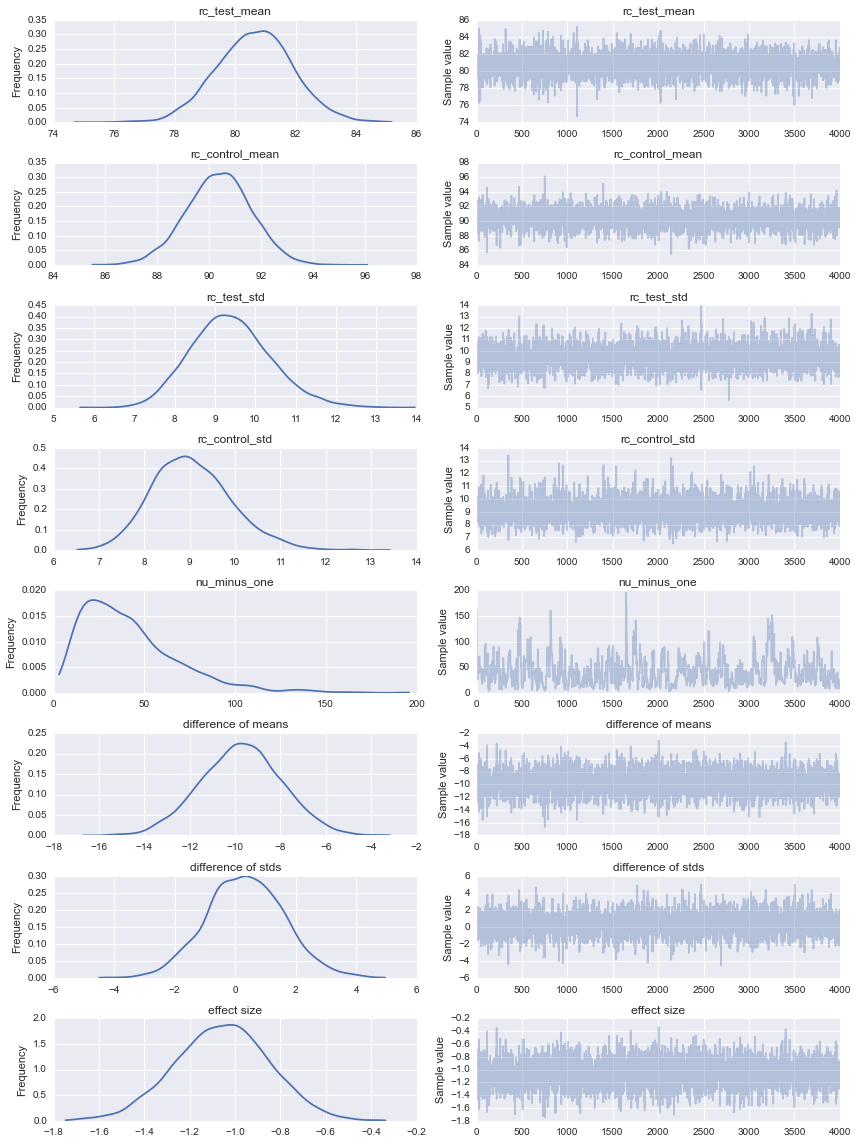

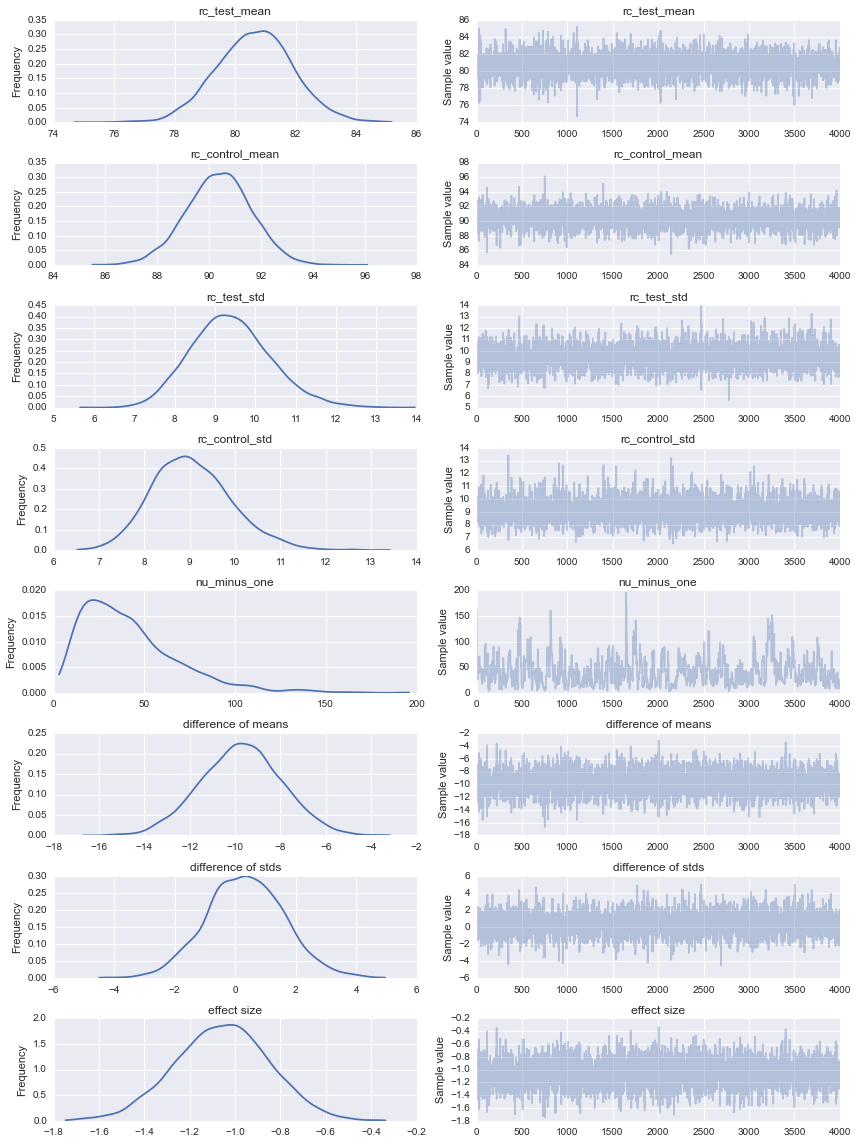

In [16]:
pm.traceplot(trace[1000:])